In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import time
start = time.time()
print(1)
from dataset import *
print(2, time.time() - start)
from modelLightning import *
print(3, time.time() - start)
import yaml
import sys

from copy import deepcopy
print(4, time.time() - start)

import argparse
from network import UNet
print(5, time.time() - start)

import lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
print(6, time.time() - start)

from modelLightning import *
print(7, time.time() - start)

import yaml
from torchsummary import summary
import sys
from eval_utils import *
print(8, time.time() - start)

device = torch.device('cuda')
torch.set_float32_matmul_precision('medium')
print(9, time.time() - start)

%load_ext autoreload
%autoreload 2


1
2 3.6676599979400635
3 5.065426826477051
4 5.065583229064941
5 5.066124677658081
6 5.2455384731292725
7 5.245625019073486
8 5.249312877655029
9 5.249415397644043


# Check pipeline proj. subsampling with L_Reg and L_Nei

In [2]:
with open('trainparamsNeighbor2InverseProjSub.yml', 'r') as f:
    trainparams = yaml.safe_load(f)

In [3]:
#initialize the datasets & dataloader
dataset_train = ProjDatasetSlice(**trainparams['dataset'], **trainparams['dataset_train'])
dataset_val = ProjDatasetSlice(**trainparams['dataset'], **trainparams['dataset_val'])

# initialize the dataloaders
dataloader_train = DataLoader(dataset_train, **trainparams['train_loader'])
dataloader_val = DataLoader(dataset_val, **trainparams['val_loader'])


Let's go! ඞ


In [4]:
batch = next(iter(dataloader_train))
proj_stack, slice_stack, pos, exptime = batch
print(pos, exptime)
print(proj_stack.shape, slice_stack.shape)
slice_stack.min(), slice_stack.max(), slice_stack.mean(), slice_stack.std()

tensor([2]) ('15ms',)
torch.Size([1, 1800, 14, 4680]) torch.Size([1, 2, 4680, 4680])


(tensor(-3.5036), tensor(3.9576), tensor(-0.0252), tensor(0.9864))

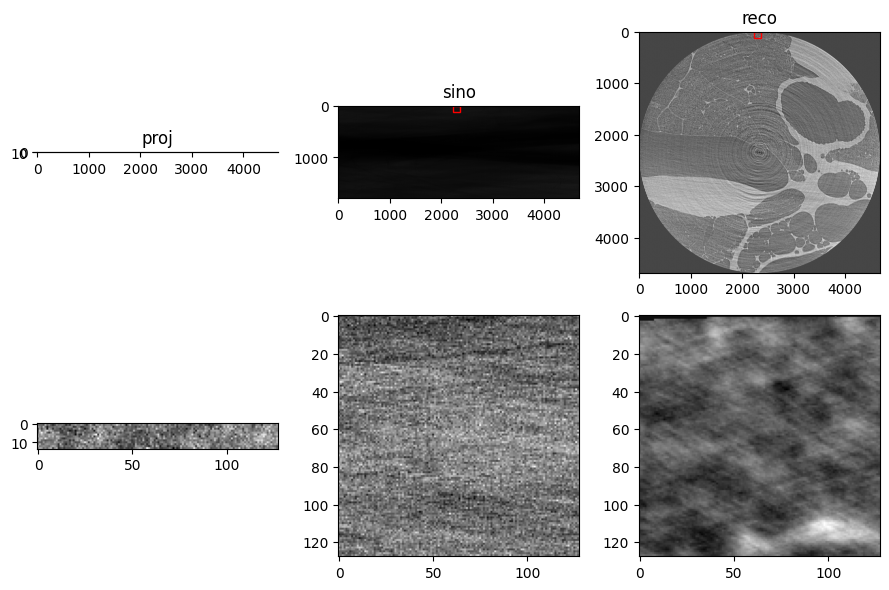

In [5]:
j = 0
k = 0
img_proj = proj_stack.squeeze()[j]
img_sino = proj_stack.squeeze()[:, k]
img_reco = slice_stack.squeeze()[j]

plot_images_with_zoom([img_proj, img_sino, img_reco], 
                      ['proj', 'sino', 'reco'],
                         vmin=None, vmax=None,
                         zoom_center=(2300, 64),
                         zoom_size=64,
                      axis=True,
)

In [6]:
base_network = UNet(**trainparams['base_network']['params'])
    
# ----- init model -----
litmodel = Neighbor2InverseSlice(network=base_network, 
                 **trainparams["lightning_params"],
                 optimizer_algo =  trainparams["optimizer_algo"],
                 scheduler_algo =  trainparams["scheduler_algo"],
                 optimizer_params = trainparams["optimizer_params"],
                 scheduler_params = trainparams["scheduler_params"],
                 n_slicesPR = trainparams["dataset"]['n_slicesPR'],
                   )

## Use test function to get intermediate images to check if everything runs as expected

In [16]:
litmodel = litmodel.cuda()
batch = [ele.cuda() for ele in [proj_stack, slice_stack]] + [pos, exptime]
print(litmodel.subsampling)
with torch.no_grad():
    noisy, reco, noisy_sub1, noisy_sub2, reco_sub1, reco_sub2, noisy_inpt, noisy_output, noisy_target, reco_denoised, forward_denoised_sub1, forward_denoised_sub2, backward_denoised_sub1, backward_denoised_sub2, loss1, loss2, loss = litmodel.get_train_images(batch, 0)

projection
noisy shape: torch.Size([1, 1800, 14, 4680]) reco shape: torch.Size([1, 2, 4680, 4680])
1800 torch.Size([1800])
noisy_sub1 shape: torch.Size([1, 1800, 7, 2340]) noisy_sub2 shape: torch.Size([1, 1800, 7, 2340])
3
noisy_sub1 pr shape: torch.Size([1, 1800, 1, 2340]) noisy_sub2 pr shape: torch.Size([1, 1800, 1, 2340])
reco_sub shape torch.Size([2, 1, 2340, 2340]) reco_sub1 shape: torch.Size([1, 1, 2340, 2340]) reco_sub2 shape: torch.Size([1, 1, 2340, 2340])
reco shape torch.Size([1, 2, 4680, 4680])
Before adjusting: mask1 shape: torch.Size([65520]) mask2 shape: torch.Size([65520])
diff 12 28080 37440 j_ 6 8
After adjusting: mask1 shape: torch.Size([9360]) mask2 shape: torch.Size([9360])
concatenate
make sinograms
reconstruct sinogram shape: torch.Size([1, 2, 1800, 2340])
split again. Recon shape: torch.Size([1, 2, 2340, 2340])
backward_denoised_sub1 shape: torch.Size([1, 1, 2340, 2340]) backward_denoised_sub2 shape: torch.Size([1, 1, 2340, 2340])


/users/Thalhammer/australienSynchrotron/venvBergen/lib/python3.12/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(-0.0247) tensor(0.9867)


/users/Thalhammer/australienSynchrotron/GITHUB/Neighbor2Inverse/Neighbor2Inverse/eval_utils.py:42: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[1, i].imshow(zoom_patch, cmap='gray', vmin=vmin, vmax=vmax)


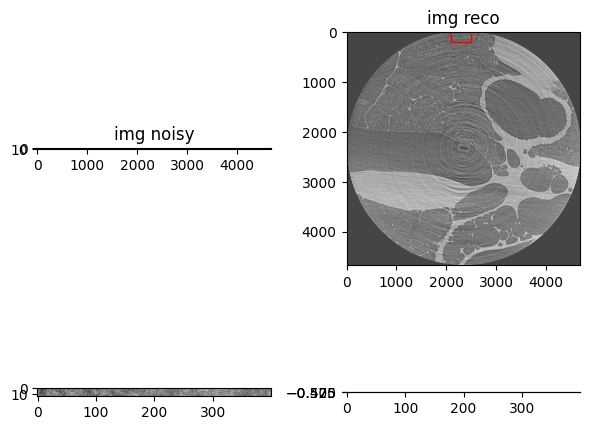

In [17]:
k = 6
img_noisy = noisy.detach().cpu().squeeze()
img_reco = reco.detach().cpu().squeeze()[0]

print(img_reco.mean(), img_reco.std())
plot_images_with_zoom([img_noisy[k], img_reco], 
                     ['img noisy', 'img reco'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(2300, 0),
                    zoom_size=200,
                    axis=True,
                    )

torch.Size([1800, 2340])


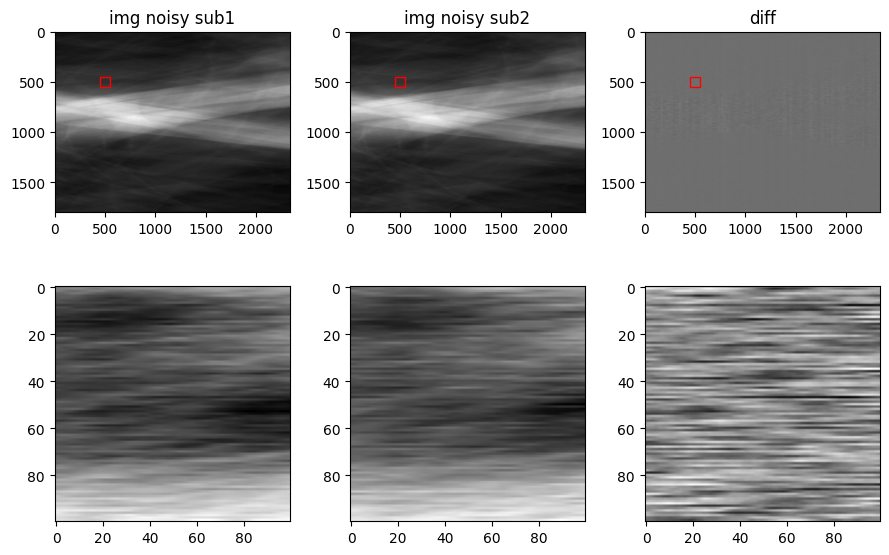

In [18]:
img_noisysub1 = noisy_sub1.detach().cpu().squeeze()
img_noisysub2 = noisy_sub2.detach().cpu().squeeze()
print(img_noisysub1.shape)
plot_images_with_zoom([img_noisysub1, img_noisysub2, img_noisysub1 - img_noisysub2], 
                     ['img noisy sub1', 'img noisy sub2', 'diff'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(500, 500),
                    zoom_size=50,
                    axis=True,
                    )

torch.Size([2340, 2340]) tensor(0.0169) tensor(0.0120)


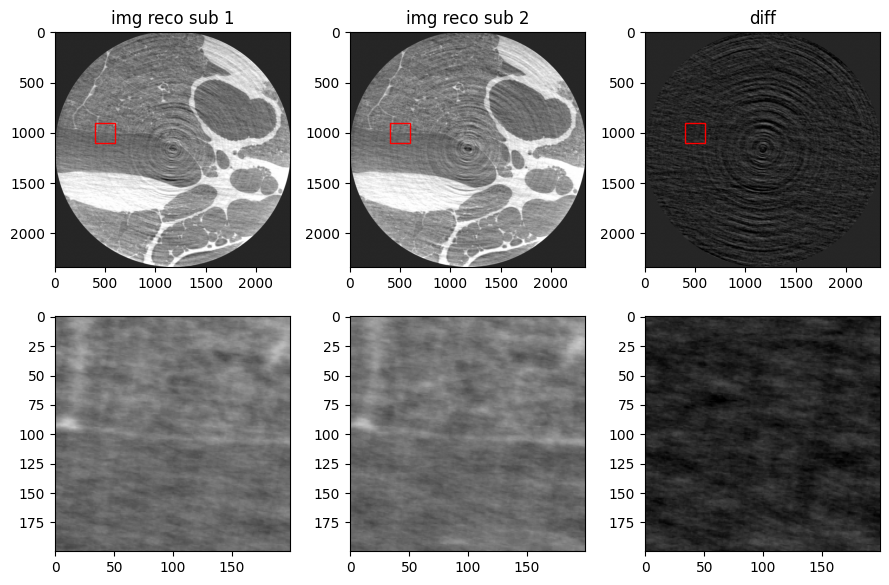

In [19]:
img_reco_sub1 = reco_sub1.detach().cpu().squeeze()
img_reco_sub2 = reco_sub2.detach().cpu().squeeze()
diff  = reco_sub2.detach().cpu().squeeze() - reco_sub1.detach().cpu().squeeze()

mn, std = img_reco_sub1.mean(), img_reco_sub1.std()
vmin = mn - 2*std
vmax = mn + 2*std

print(img_reco_sub2.shape, img_reco_sub2.mean(), img_reco_sub2.std())
plot_images_with_zoom([img_reco_sub1, img_reco_sub2, diff], 
                     ['img reco sub 1', 'img reco sub 2', 'diff'],
                    vmin=vmin,
                    vmax=vmax,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

tensor(-0.0451, device='cuda:0') tensor(0.9379, device='cuda:0')


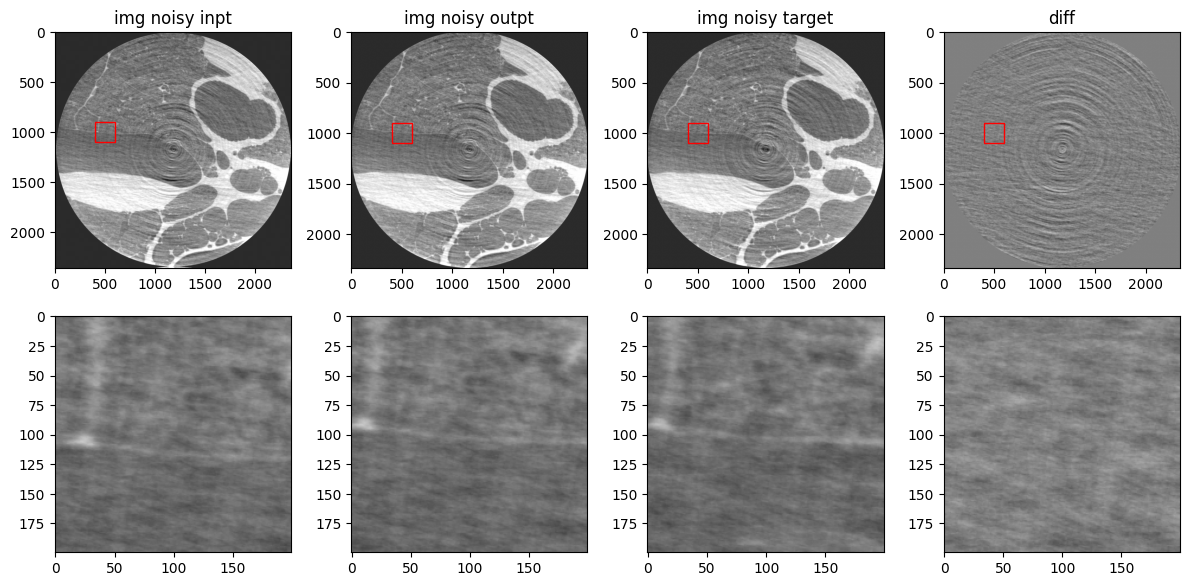

In [20]:
img_list = [img.detach().squeeze().cpu() for img in [noisy_inpt, noisy_output, noisy_target, noisy_output-noisy_target]]
print(noisy_inpt.mean(), noisy_inpt.std())
plot_images_with_zoom(img_list, 
                     ['img noisy inpt', 'img noisy outpt', 'img noisy target', 'diff'],
                    vmin=-2,
                    vmax=2,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

tensor(-0.0591, device='cuda:0') tensor(0.9634, device='cuda:0')


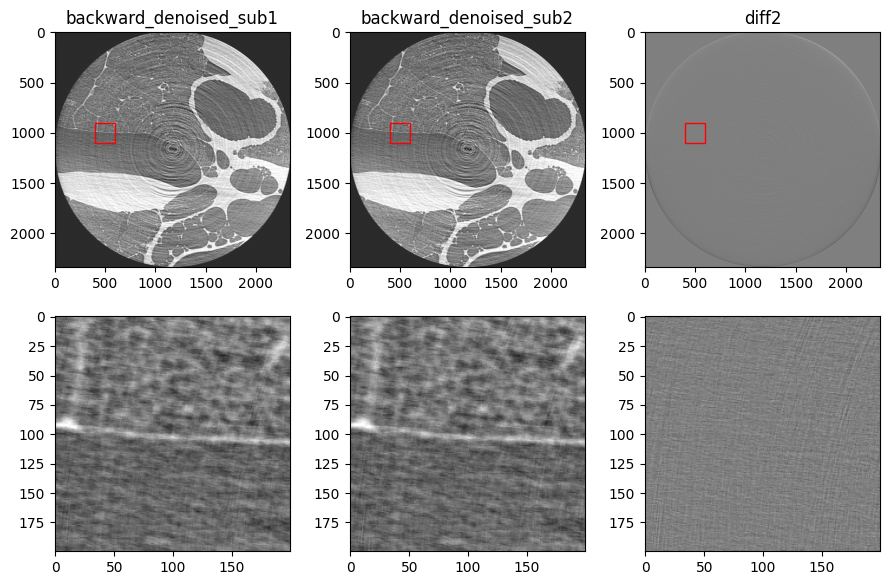

In [23]:
img_list = [img[0].detach().squeeze().cpu() for img in [backward_denoised_sub1, backward_denoised_sub2, backward_denoised_sub1-backward_denoised_sub2]]
print(backward_denoised_sub1.mean(), backward_denoised_sub1.std())
plot_images_with_zoom(img_list, 
                     ['backward_denoised_sub1', 'backward_denoised_sub2', 'diff2'],
                    vmin=-2,
                    vmax=2,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

In [24]:
print(loss1, loss2, loss)

tensor(0.0438, device='cuda:0') tensor(0.0582, device='cuda:0') tensor(0.1021, device='cuda:0')


# Check pipeline proj. subsampling with L_Reg and L_Nei

In [25]:
with open('trainparamsNeighbor2InverseSinoSub.yml', 'r') as f:
    trainparams = yaml.safe_load(f)

In [26]:
#initialize the datasets & dataloader
dataset_train = ProjDatasetSlice(**trainparams['dataset'], **trainparams['dataset_train'])
dataset_val = ProjDatasetSlice(**trainparams['dataset'], **trainparams['dataset_val'])

# initialize the dataloaders
dataloader_train = DataLoader(dataset_train, **trainparams['train_loader'])
dataloader_val = DataLoader(dataset_val, **trainparams['val_loader'])


Let's go! ඞ


In [27]:
batch = next(iter(dataloader_train))
proj_stack, slice_stack, pos, exptime = batch
print(pos, exptime)
print(proj_stack.shape, slice_stack.shape)
slice_stack.min(), slice_stack.max(), slice_stack.mean(), slice_stack.std()

tensor([2]) ('15ms',)
torch.Size([1, 1800, 14, 4680]) torch.Size([1, 1, 4680, 4680])


(tensor(-2.2270), tensor(4.1312), tensor(-0.0302), tensor(0.9350))

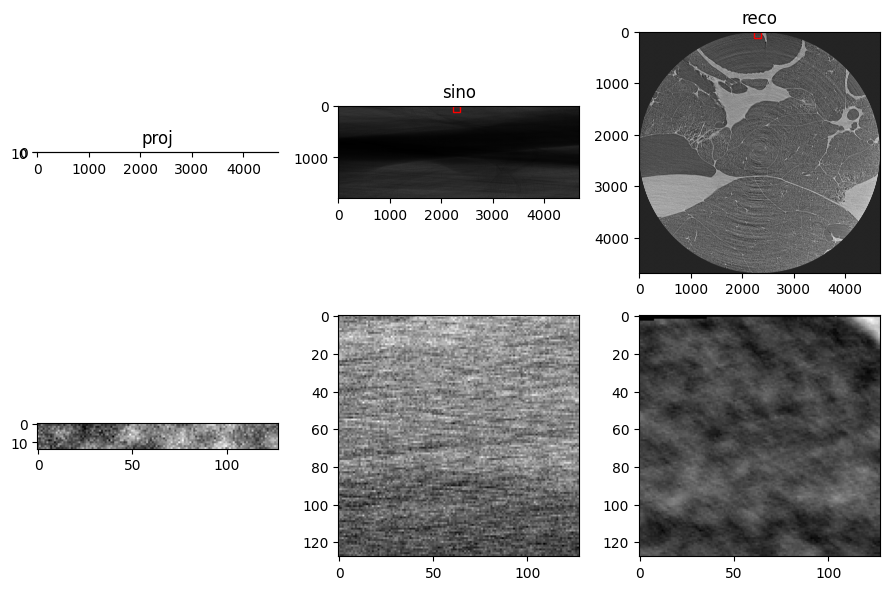

In [29]:
j = 0
k = 0
img_proj = proj_stack.squeeze()[j]
img_sino = proj_stack.squeeze()[:, k]
img_reco = slice_stack.squeeze()

plot_images_with_zoom([img_proj, img_sino, img_reco], 
                      ['proj', 'sino', 'reco'],
                         vmin=None, vmax=None,
                         zoom_center=(2300, 64),
                         zoom_size=64,
                      axis=True,
)

In [30]:
base_network = UNet(**trainparams['base_network']['params'])
    
# ----- init model -----
litmodel = Neighbor2InverseSlice(network=base_network, 
                 **trainparams["lightning_params"],
                 optimizer_algo =  trainparams["optimizer_algo"],
                 scheduler_algo =  trainparams["scheduler_algo"],
                 optimizer_params = trainparams["optimizer_params"],
                 scheduler_params = trainparams["scheduler_params"],
                 n_slicesPR = trainparams["dataset"]['n_slicesPR'],
                   )

In [31]:
litmodel = litmodel.cuda()
batch = [ele.cuda() for ele in [proj_stack, slice_stack]] + [pos, exptime]
print(litmodel.subsampling)
with torch.no_grad():
    noisy, reco, noisy_sub1, noisy_sub2, reco_sub1, reco_sub2, noisy_inpt, noisy_output, noisy_target, loss = litmodel.get_train_images(batch, 0)

sinogram
noisy shape: torch.Size([1, 1800, 14, 4680]) reco shape: torch.Size([1, 1, 4680, 4680])
1800 torch.Size([1800])
noisy_sub1 shape: torch.Size([1, 900, 14, 2340]) noisy_sub2 shape: torch.Size([1, 900, 14, 2340])
7
noisy_sub1 pr shape: torch.Size([1, 900, 1, 2340]) noisy_sub2 pr shape: torch.Size([1, 900, 1, 2340])
reco_sub shape torch.Size([2, 1, 2340, 2340]) reco_sub1 shape: torch.Size([1, 1, 2340, 2340]) reco_sub2 shape: torch.Size([1, 1, 2340, 2340])


tensor(-0.0302) tensor(0.9350)


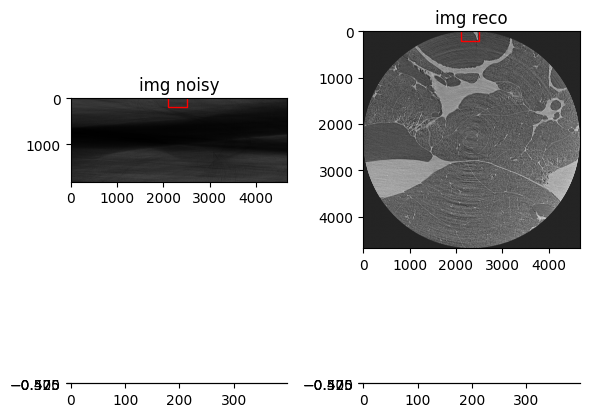

In [33]:
k = 6
img_noisy = noisy.detach().cpu().squeeze()
img_reco = reco.detach().cpu().squeeze()

print(img_reco.mean(), img_reco.std())
plot_images_with_zoom([img_noisy[k], img_reco], 
                     ['img noisy', 'img reco'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(2300, 0),
                    zoom_size=200,
                    axis=True,
                    )

torch.Size([900, 2340])


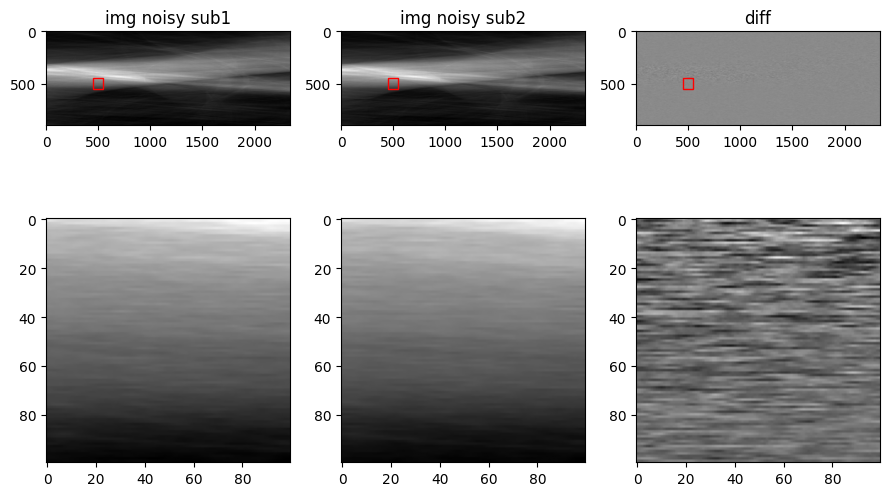

In [34]:
img_noisysub1 = noisy_sub1.detach().cpu().squeeze()
img_noisysub2 = noisy_sub2.detach().cpu().squeeze()
print(img_noisysub1.shape)
plot_images_with_zoom([img_noisysub1, img_noisysub2, img_noisysub1 - img_noisysub2], 
                     ['img noisy sub1', 'img noisy sub2', 'diff'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(500, 500),
                    zoom_size=50,
                    axis=True,
                    )

torch.Size([2340, 2340]) tensor(0.0169) tensor(0.0129)


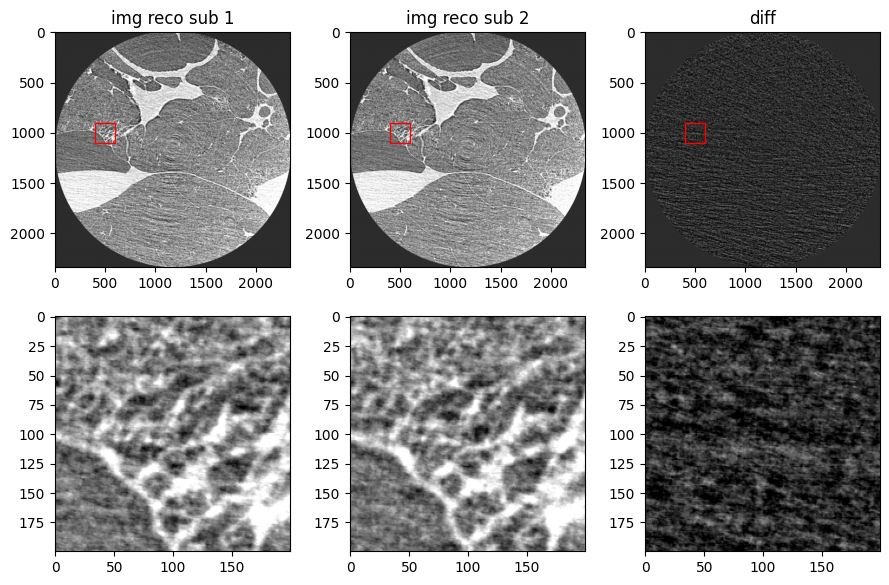

In [35]:
img_reco_sub1 = reco_sub1.detach().cpu().squeeze()
img_reco_sub2 = reco_sub2.detach().cpu().squeeze()
diff  = reco_sub2.detach().cpu().squeeze() - reco_sub1.detach().cpu().squeeze()

mn, std = img_reco_sub1.mean(), img_reco_sub1.std()
vmin = mn - 2*std
vmax = mn + 2*std

print(img_reco_sub2.shape, img_reco_sub2.mean(), img_reco_sub2.std())
plot_images_with_zoom([img_reco_sub1, img_reco_sub2, diff], 
                     ['img reco sub 1', 'img reco sub 2', 'diff'],
                    vmin=vmin,
                    vmax=vmax,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

tensor(-0.0577, device='cuda:0') tensor(1.0010, device='cuda:0')


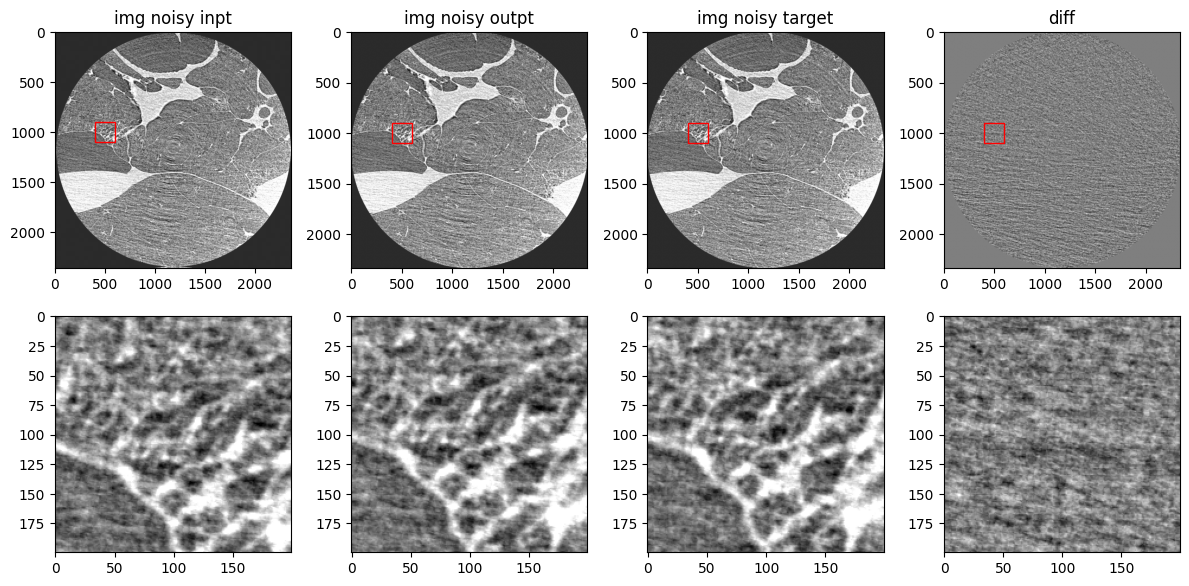

In [36]:
img_list = [img.detach().squeeze().cpu() for img in [noisy_inpt, noisy_output, noisy_target, noisy_output-noisy_target]]
print(noisy_inpt.mean(), noisy_inpt.std())
plot_images_with_zoom(img_list, 
                     ['img noisy inpt', 'img noisy outpt', 'img noisy target', 'diff'],
                    vmin=-2,
                    vmax=2,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

tensor(-0.0591, device='cuda:0') tensor(0.9634, device='cuda:0')


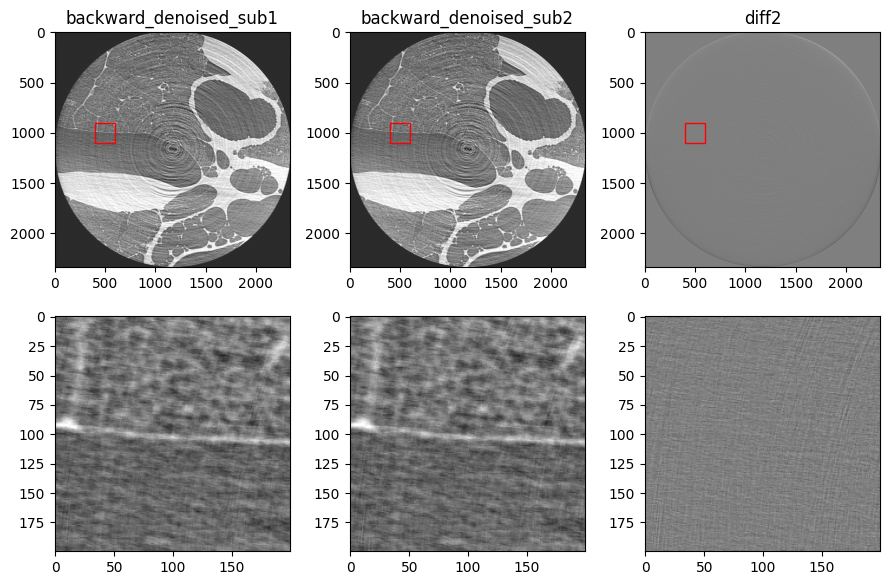

In [37]:
img_list = [img[0].detach().squeeze().cpu() for img in [backward_denoised_sub1, backward_denoised_sub2, backward_denoised_sub1-backward_denoised_sub2]]
print(backward_denoised_sub1.mean(), backward_denoised_sub1.std())
plot_images_with_zoom(img_list, 
                     ['backward_denoised_sub1', 'backward_denoised_sub2', 'diff2'],
                    vmin=-2,
                    vmax=2,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

In [38]:
print(loss)

tensor(0.1948, device='cuda:0')


# Check pipeline Data Fidelity - virt Sinogram

In [3]:
with open('trainparamsDataFidelityVirtSino.yml', 'r') as f:
    trainparams = yaml.safe_load(f)

In [4]:
#initialize the datasets & dataloader
dataset_train = ProjDatasetSlice(**trainparams['dataset'], **trainparams['dataset_train'])
dataset_val = ProjDatasetSlice(**trainparams['dataset'], **trainparams['dataset_val'])

# initialize the dataloaders
dataloader_train = DataLoader(dataset_train, **trainparams['train_loader'])
dataloader_val = DataLoader(dataset_val, **trainparams['val_loader'])


Let's go! ඞ


In [5]:
batch = next(iter(dataloader_train))
proj_stack, slice_stack, pos, exptime = batch
print(pos, exptime)
print(proj_stack.shape, slice_stack.shape)
slice_stack.min(), slice_stack.max(), slice_stack.mean(), slice_stack.std()

tensor([2]) ('15ms',)
torch.Size([1, 1800, 14, 4680]) torch.Size([1, 2, 4680, 4680])


(tensor(-2.3490), tensor(4.5440), tensor(-0.0220), tensor(0.9434))

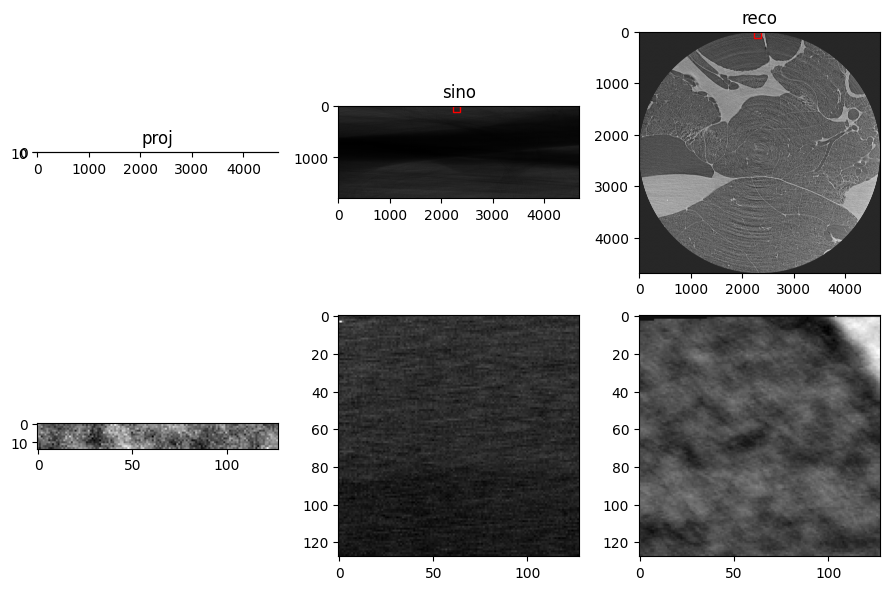

In [6]:
j = 0
k = 0
img_proj = proj_stack.squeeze()[j]
img_sino = proj_stack.squeeze()[:, k]
img_reco = slice_stack.squeeze()[j]

plot_images_with_zoom([img_proj, img_sino, img_reco], 
                      ['proj', 'sino', 'reco'],
                         vmin=None, vmax=None,
                         zoom_center=(2300, 64),
                         zoom_size=64,
                      axis=True,
)

In [7]:
base_network = UNet(**trainparams['base_network']['params'])
    
# ----- init model -----
litmodel = Neighbor2InverseDataFidelity(network=base_network, 
                 **trainparams["lightning_params"],
                 optimizer_algo =  trainparams["optimizer_algo"],
                 scheduler_algo =  trainparams["scheduler_algo"],
                 optimizer_params = trainparams["optimizer_params"],
                 scheduler_params = trainparams["scheduler_params"],
                 n_slicesPR = trainparams["dataset"]['n_slicesPR'],
                   )

In [8]:
litmodel = litmodel.cuda()
batch = [ele.cuda() for ele in [proj_stack, slice_stack]] + [pos, exptime]
print(litmodel.subsampling)
with torch.no_grad():
    noisy, noisy_sub1, noisy_sub2, reco_sub1, reco_sub2, noisy_inpt, noisy_output, noisy_target, forward_denoised, forward_denoised_pp, forward_reco, forward_reco_pp, lossN2N, fidelity_loss, loss = litmodel.get_train_images(batch, 0)

projection
noisy shape: torch.Size([1, 1800, 14, 4680]) reco shape: torch.Size([1, 2, 4680, 4680])
1800 torch.Size([1800])
noisy_sub1 shape: torch.Size([1, 1800, 7, 2340]) noisy_sub2 shape: torch.Size([1, 1800, 7, 2340])
3
noisy_sub1 pr shape: torch.Size([1, 1800, 1, 2340]) noisy_sub2 pr shape: torch.Size([1, 1800, 1, 2340])
reco_sub shape torch.Size([2, 1, 2340, 2340]) reco_sub1 shape: torch.Size([1, 1, 2340, 2340]) reco_sub2 shape: torch.Size([1, 1, 2340, 2340])
forward_output shape: torch.Size([1800, 1, 1, 2340])
torch.Size([1800, 1, 101, 4340])
forward denoised pp shape torch.Size([1800, 1, 101, 4340])
forward denoised pp shape after removing pad torch.Size([1800, 1, 1, 2340])
calculating fidelity loss with virtual
forward reco, forward output shape torch.Size([1800, 1, 1, 2340]) torch.Size([1800, 1, 101, 4340])
torch.Size([1800, 1, 101, 4340])


/users/Thalhammer/australienSynchrotron/venvBergen/lib/python3.12/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


torch.Size([1800, 2340])


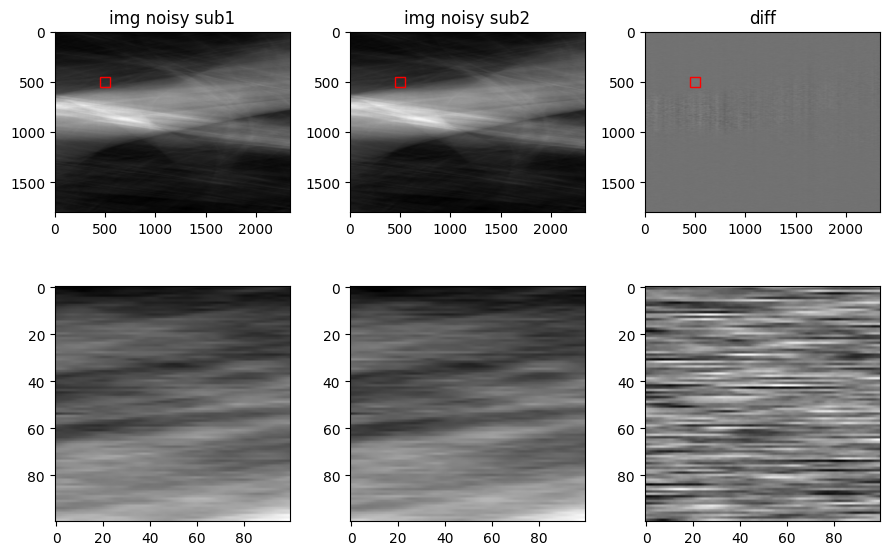

In [9]:
img_noisysub1 = noisy_sub1.detach().cpu().squeeze()
img_noisysub2 = noisy_sub2.detach().cpu().squeeze()
print(img_noisysub1.shape)
plot_images_with_zoom([img_noisysub1, img_noisysub2, img_noisysub1 - img_noisysub2], 
                     ['img noisy sub1', 'img noisy sub2', 'diff'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(500, 500),
                    zoom_size=50,
                    axis=True,
                    )

torch.Size([2340, 2340]) tensor(0.0171) tensor(0.0115)


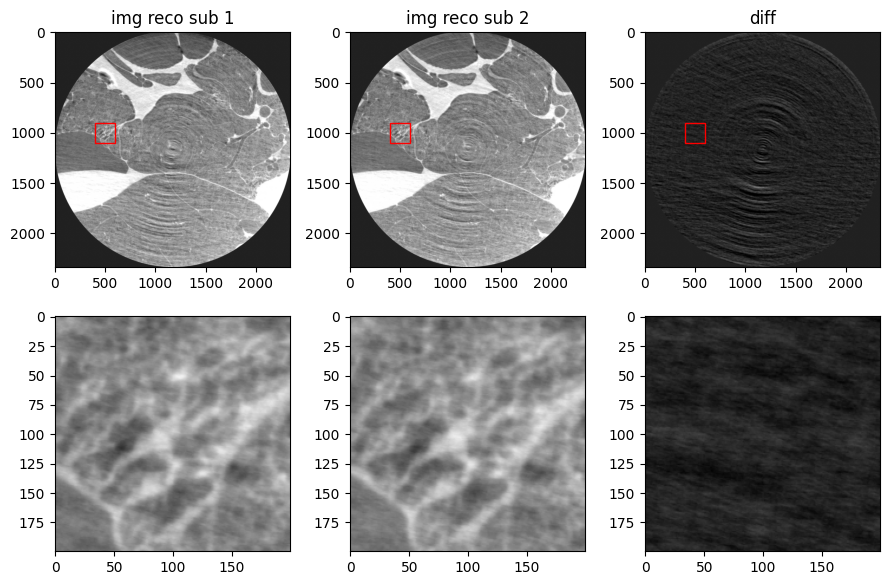

In [10]:
img_reco_sub1 = reco_sub1.detach().cpu().squeeze()
img_reco_sub2 = reco_sub2.detach().cpu().squeeze()
diff  = reco_sub2.detach().cpu().squeeze() - reco_sub1.detach().cpu().squeeze()

mn, std = img_reco_sub1.mean(), img_reco_sub1.std()
vmin = mn - 2*std
vmax = mn + 2*std

print(img_reco_sub2.shape, img_reco_sub2.mean(), img_reco_sub2.std())
plot_images_with_zoom([img_reco_sub1, img_reco_sub2, diff], 
                     ['img reco sub 1', 'img reco sub 2', 'diff'],
                    vmin=vmin,
                    vmax=vmax,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

tensor(-0.0597, device='cuda:0') tensor(0.8883, device='cuda:0')
tensor(-0.0073, device='cuda:0') tensor(0.8860, device='cuda:0')


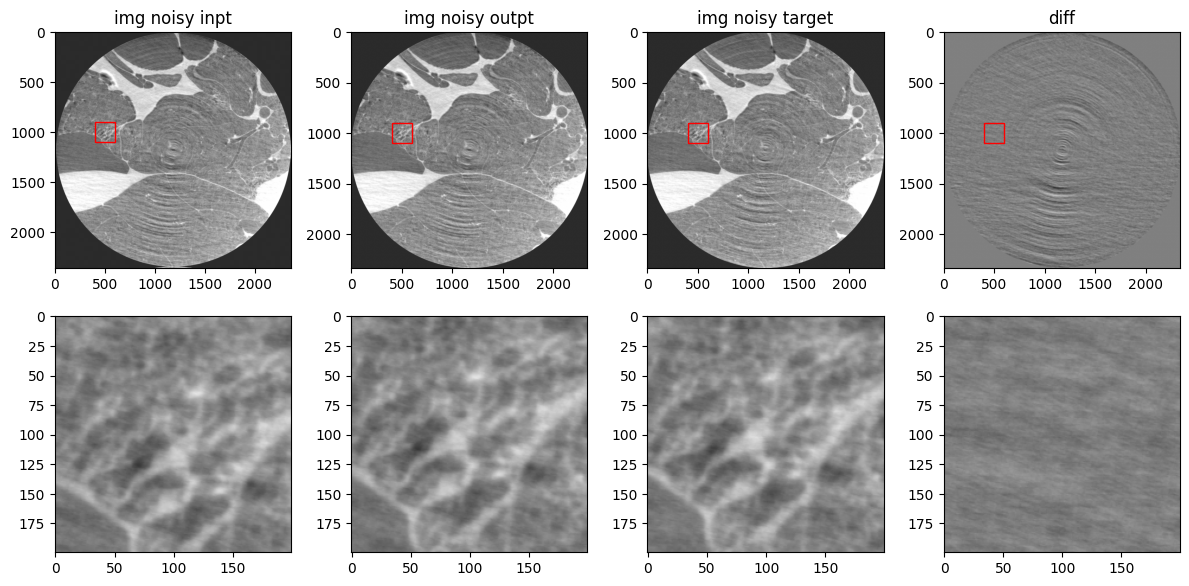

In [11]:
img_list = [img.detach().squeeze().cpu() for img in [noisy_inpt, noisy_output, noisy_target, noisy_output-noisy_target]]
print(noisy_inpt.mean(), noisy_inpt.std())
print(noisy_target.mean(), noisy_target.std())
 
plot_images_with_zoom(img_list, 
                     ['img noisy inpt', 'img noisy outpt', 'img noisy target', 'diff'],
                    vmin=-2,
                    vmax=2,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

torch.Size([1800, 1, 101, 4340])
tensor(21.7892, device='cuda:0') tensor(20.8230, device='cuda:0')


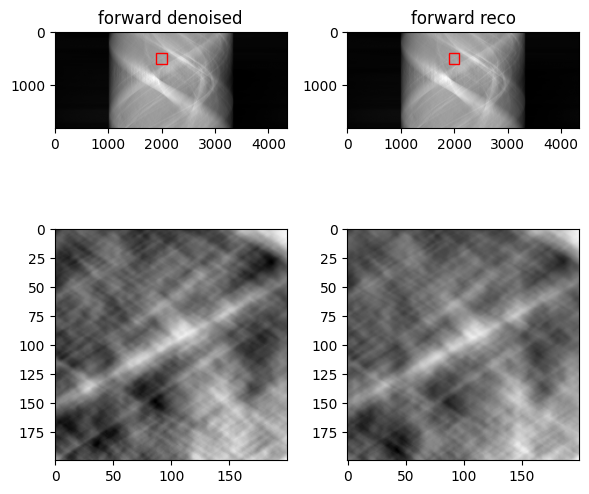

In [12]:
print(forward_denoised.shape)
#print(forward_reco.mean(), forward_reco.std())
img_list = [img[:, :, 50].detach().squeeze().cpu() for img in [forward_denoised, forward_reco]]
print(forward_denoised.mean(), forward_denoised.std())
#print(forward_reco.mean(), forward_reco.std())
plot_images_with_zoom(img_list, 
                     ['forward denoised', 'forward reco'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(2000, 500),
                    zoom_size=100,
                    axis=True,
                    )

torch.Size([1800, 1, 1, 2340]) torch.Size([1800, 1, 1, 2340])
tensor(0.7594, device='cuda:0') tensor(0.0661, device='cuda:0')
tensor(0.7551, device='cuda:0') tensor(0.0653, device='cuda:0')


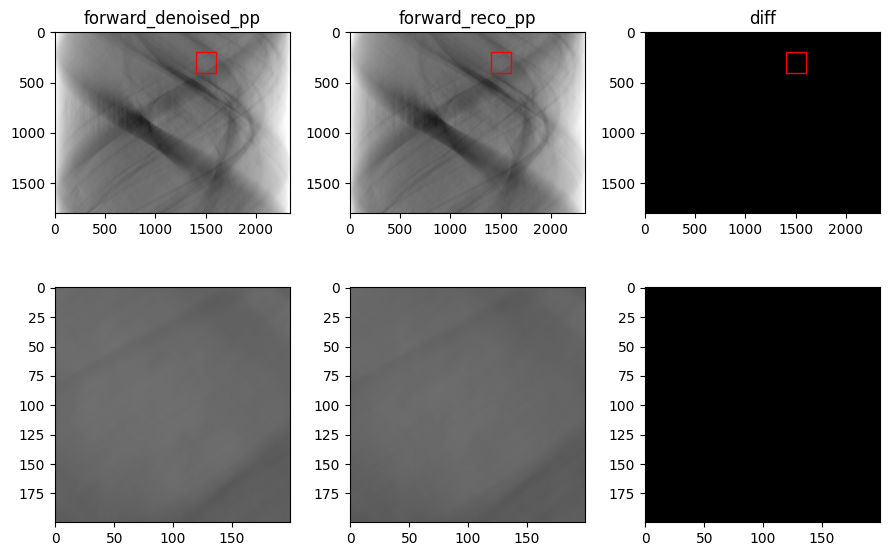

In [17]:
print(forward_denoised_pp.shape, forward_reco_pp.shape)
img_list = [img.detach().squeeze().cpu() for img in [forward_denoised_pp, forward_reco_pp, forward_denoised_pp -forward_reco_pp]]
print(forward_denoised_pp.mean(), forward_denoised_pp.std())
print(forward_reco_pp.mean(), forward_reco_pp.std())
mn, std = forward_denoised_pp.mean(), forward_denoised_pp.std()
vmin = mn - 3*std
vmax = mn + 3*std
plot_images_with_zoom(img_list, 
                     ['forward_denoised_pp', 'forward_reco_pp', 'diff'],
                    vmin=vmin,
                    vmax=vmax,
                    zoom_center=(1500, 300),
                    zoom_size=100,
                    axis=True,
                    )

# Check pipeline Data Fidelity - orig Sinogram

In [2]:
with open('trainparamsDataFidelityOrigSino.yml', 'r') as f:
    trainparams = yaml.safe_load(f)

In [3]:
#initialize the datasets & dataloader
dataset_train = ProjDatasetSlice(**trainparams['dataset'], **trainparams['dataset_train'])
dataset_val = ProjDatasetSlice(**trainparams['dataset'], **trainparams['dataset_val'])

# initialize the dataloaders
dataloader_train = DataLoader(dataset_train, **trainparams['train_loader'])
dataloader_val = DataLoader(dataset_val, **trainparams['val_loader'])


Let's go! ඞ


In [4]:
batch = next(iter(dataloader_train))
proj_stack, slice_stack, pos, exptime = batch
print(pos, exptime)
print(proj_stack.shape, slice_stack.shape)
slice_stack.min(), slice_stack.max(), slice_stack.mean(), slice_stack.std()

tensor([2]) ('15ms',)
torch.Size([1, 1800, 14, 4680]) torch.Size([1, 2, 4680, 4680])


(tensor(-2.6299), tensor(4.1875), tensor(-0.0152), tensor(0.9500))

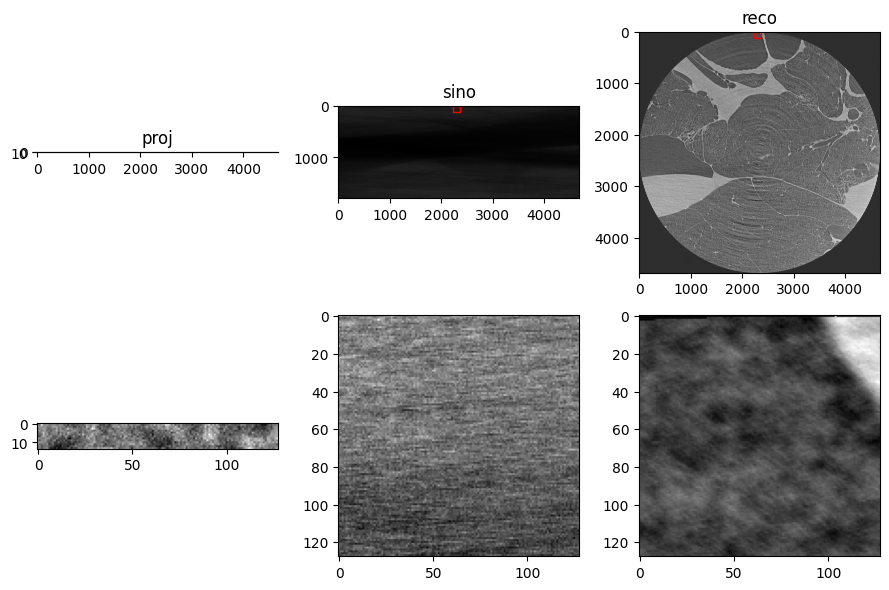

In [5]:
j = 0
k = 0
img_proj = proj_stack.squeeze()[j]
img_sino = proj_stack.squeeze()[:, k]
img_reco = slice_stack.squeeze()[j]

plot_images_with_zoom([img_proj, img_sino, img_reco], 
                      ['proj', 'sino', 'reco'],
                         vmin=None, vmax=None,
                         zoom_center=(2300, 64),
                         zoom_size=64,
                      axis=True,
)

In [6]:
base_network = UNet(**trainparams['base_network']['params'])
    
# ----- init model -----
litmodel = Neighbor2InverseDataFidelity(network=base_network, 
                 **trainparams["lightning_params"],
                 optimizer_algo =  trainparams["optimizer_algo"],
                 scheduler_algo =  trainparams["scheduler_algo"],
                 optimizer_params = trainparams["optimizer_params"],
                 scheduler_params = trainparams["scheduler_params"],
                 n_slicesPR = trainparams["dataset"]['n_slicesPR'],
                   )

In [7]:
litmodel = litmodel.cuda()
batch = [ele.cuda() for ele in [proj_stack, slice_stack]] + [pos, exptime]
print(litmodel.subsampling)
with torch.no_grad():
    noisy, noisy_sub1, noisy_sub2, reco_sub1, reco_sub2, noisy_inpt, noisy_output, noisy_target, forward_denoised, forward_denoised_pp, noisy_measurement_target, lossN2N, fidelity_loss, loss = litmodel.get_train_images(batch, 0)

projection
noisy shape: torch.Size([1, 1800, 14, 4680]) reco shape: torch.Size([1, 2, 4680, 4680])
1800 torch.Size([1800])
noisy_sub1 shape: torch.Size([1, 1800, 7, 2340]) noisy_sub2 shape: torch.Size([1, 1800, 7, 2340])
3
3
noisy_sub1 pr shape: torch.Size([1, 1800, 1, 2340]) noisy_sub2 pr shape: torch.Size([1, 1800, 1, 2340])
reco_sub shape torch.Size([2, 1, 2340, 2340]) reco_sub1 shape: torch.Size([1, 1, 2340, 2340]) reco_sub2 shape: torch.Size([1, 1, 2340, 2340])
forward_output shape: torch.Size([1800, 1, 1, 2340])
torch.Size([1800, 1, 101, 4340])
forward denoised pp shape torch.Size([1800, 1, 101, 4340])
forward denoised pp shape after removing pad torch.Size([1800, 1, 1, 2340])
torch.cuda.memory_allocated: 6.971507GB
torch.cuda.memory_reserved: 9.505859GB
torch.cuda.max_memory_reserved: 22.345703GB
data fidelity with raw measured data
forward_denoised shape torch.Size([1800, 1, 1, 2340])
noisy_measurement_target shape torch.Size([1800, 1, 1, 2340])


/users/Thalhammer/australienSynchrotron/venvBergen/lib/python3.12/site-packages/lightning/pytorch/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


torch.Size([1800, 2340])


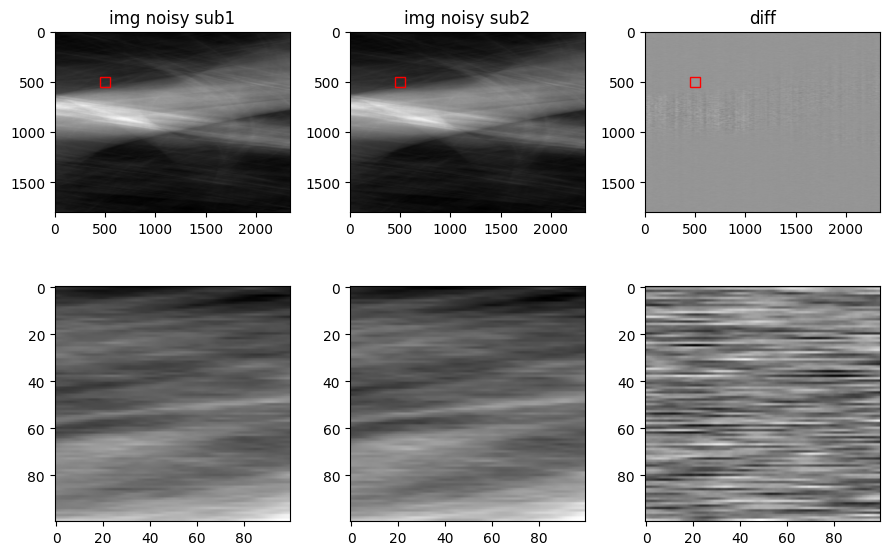

In [8]:
img_noisysub1 = noisy_sub1.detach().cpu().squeeze()
img_noisysub2 = noisy_sub2.detach().cpu().squeeze()
print(img_noisysub1.shape)
plot_images_with_zoom([img_noisysub1, img_noisysub2, img_noisysub1 - img_noisysub2], 
                     ['img noisy sub1', 'img noisy sub2', 'diff'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(500, 500),
                    zoom_size=50,
                    axis=True,
                    )

torch.Size([2340, 2340]) tensor(0.0170) tensor(0.0115)


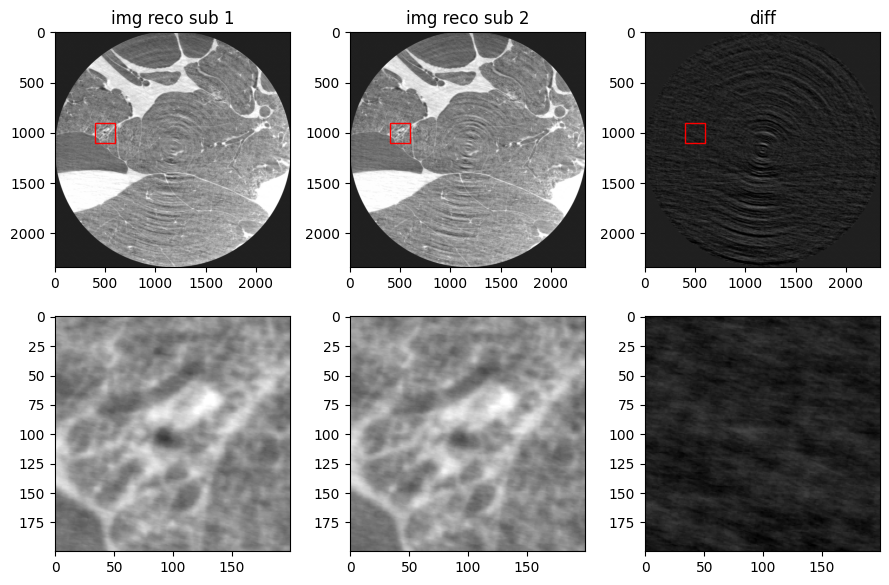

In [9]:
img_reco_sub1 = reco_sub1.detach().cpu().squeeze()
img_reco_sub2 = reco_sub2.detach().cpu().squeeze()
diff  = reco_sub2.detach().cpu().squeeze() - reco_sub1.detach().cpu().squeeze()

mn, std = img_reco_sub1.mean(), img_reco_sub1.std()
vmin = mn - 2*std
vmax = mn + 2*std

print(img_reco_sub2.shape, img_reco_sub2.mean(), img_reco_sub2.std())
plot_images_with_zoom([img_reco_sub1, img_reco_sub2, diff], 
                     ['img reco sub 1', 'img reco sub 2', 'diff'],
                    vmin=vmin,
                    vmax=vmax,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

tensor(-0.0408, device='cuda:0') tensor(0.8926, device='cuda:0')
tensor(-0.0188, device='cuda:0') tensor(0.8801, device='cuda:0')


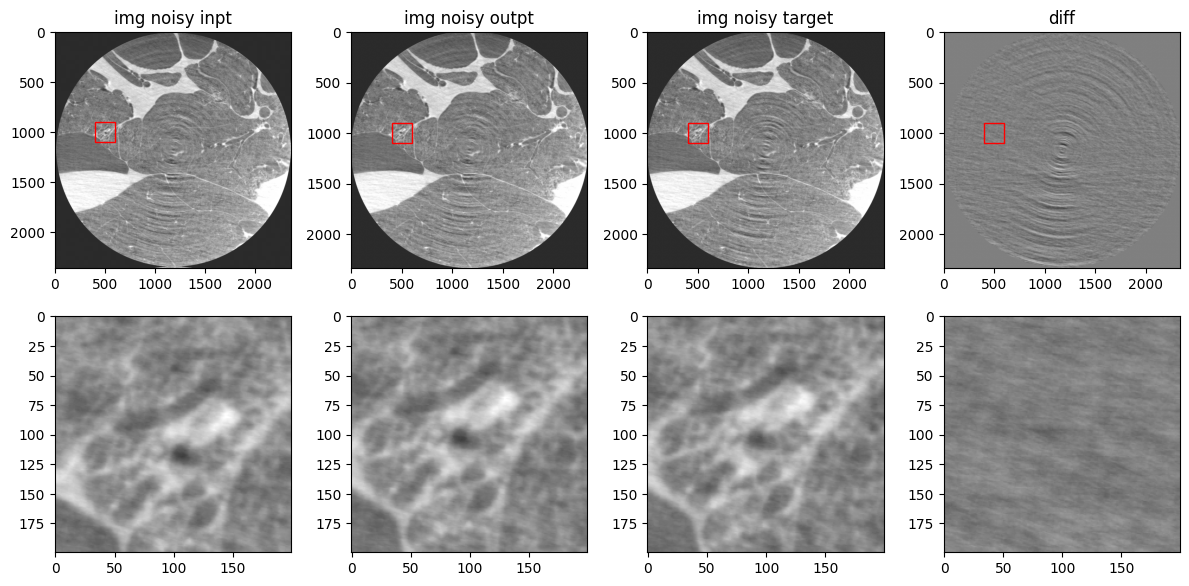

In [10]:
img_list = [img.detach().squeeze().cpu() for img in [noisy_inpt, noisy_output, noisy_target, noisy_output-noisy_target]]
print(noisy_inpt.mean(), noisy_inpt.std())
print(noisy_target.mean(), noisy_target.std())
 
plot_images_with_zoom(img_list, 
                     ['img noisy inpt', 'img noisy outpt', 'img noisy target', 'diff'],
                    vmin=-2,
                    vmax=2,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

torch.Size([1800, 1, 101, 4340])
tensor(0.7562, device='cuda:0') tensor(0.0653, device='cuda:0')


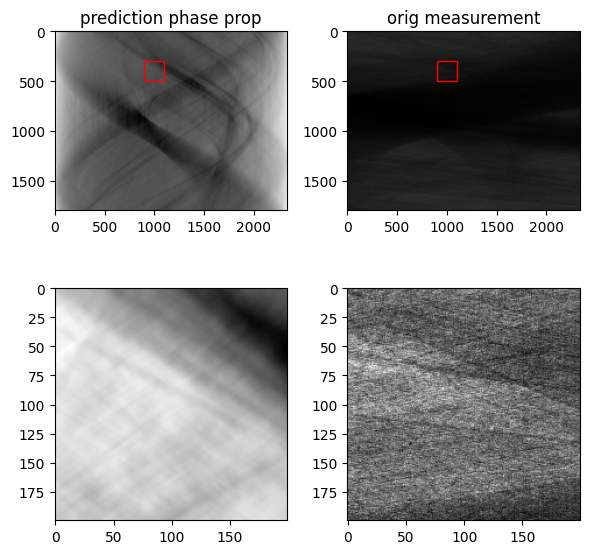

In [24]:
print(forward_denoised.shape)
#print(forward_reco.mean(), forward_reco.std())
img_list = [img.detach().squeeze().cpu() for img in [forward_denoised_pp, noisy_measurement_target]]
print(forward_denoised_pp.mean(), forward_denoised_pp.std())

mn, std = forward_denoised_pp.mean(), forward_denoised_pp.std()
vmin = mn - 3*std
vmax = mn + 3*std
#print(forward_reco.mean(), forward_reco.std())
plot_images_with_zoom(img_list, 
                     ['prediction phase prop', 'orig measurement'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(1000, 400),
                    zoom_size=100,
                    axis=True,
                    )


In [25]:
print(lossN2N, fidelity_loss, loss)

tensor(0.0253, device='cuda:0') tensor(0.3495, device='cuda:0') tensor(0.0603, device='cuda:0')


# Check pipeline sparse training

In [11]:
with open('trainparamsSparse.yml', 'r') as f:
    trainparams = yaml.safe_load(f)

In [3]:
#initialize the datasets & dataloader
dataset_train = ProjDataset(**trainparams['dataset'], **trainparams['dataset_train'])
dataset_val = ProjDataset(**trainparams['dataset'], **trainparams['dataset_val'])

# initialize the dataloaders
dataloader_train = DataLoader(dataset_train, **trainparams['train_loader'])
dataloader_val = DataLoader(dataset_val, **trainparams['val_loader'])


Let's go! ඞ


In [5]:
batch = next(iter(dataloader_train))
proj_stack, pos, exptime = batch
print(pos, exptime)
print(proj_stack.shape)
proj_stack.min(), proj_stack.max(), proj_stack.mean(), proj_stack.std()

tensor([5]) ('15ms',)
torch.Size([1, 900, 14, 4652])


(tensor(1.2517e-06), tensor(2.0449), tensor(0.1750), tensor(0.0842))

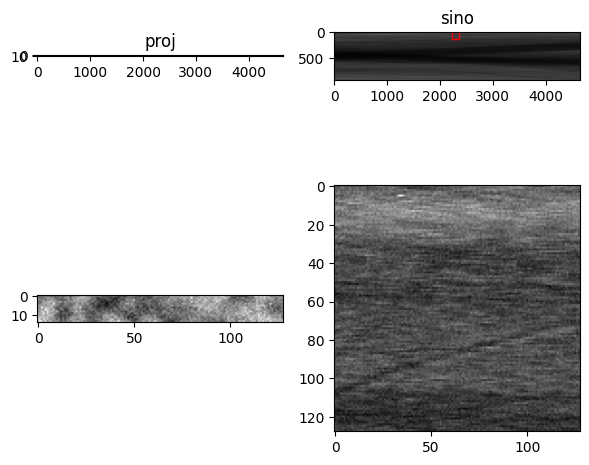

In [6]:
j = 0
k = 0
img_proj = proj_stack.squeeze()[j]
img_sino = proj_stack.squeeze()[:, k]

plot_images_with_zoom([img_proj, img_sino], 
                      ['proj', 'sino'],
                         vmin=None, vmax=None,
                         zoom_center=(2300, 64),
                         zoom_size=64,
                      axis=True,
)

In [14]:
base_network = UNet(**trainparams['base_network']['params'])
    
# ----- init model -----
litmodel = Neighbor2InverseSlice(network=base_network, 
                 **trainparams["lightning_params"],
                 optimizer_algo =  trainparams["optimizer_algo"],
                 scheduler_algo =  trainparams["scheduler_algo"],
                 optimizer_params = trainparams["optimizer_params"],
                 scheduler_params = trainparams["scheduler_params"],
                 n_slicesPR = trainparams["dataset"]['n_slicesPR'],
                   )

In [15]:
litmodel = litmodel.cuda()
batch = [ele.cuda() for ele in [proj_stack]] + [pos, exptime]
print(litmodel.subsampling)
with torch.no_grad():
    noisy, noisy_sub1, noisy_sub2, reco_sub1, reco_sub2, noisy_inpt, noisy_output, noisy_target, loss = litmodel.get_train_images(batch, 0)

projection
batch length: 3
noisy shape: torch.Size([1, 900, 14, 4652]) pos: tensor([5]) exptime: ('15ms',)
900 torch.Size([900])
noisy_sub1 shape: torch.Size([1, 900, 7, 2326]) noisy_sub2 shape: torch.Size([1, 900, 7, 2326])
3
noisy_sub1 pr shape: torch.Size([1, 900, 1, 2326]) noisy_sub2 pr shape: torch.Size([1, 900, 1, 2326])
reco_sub shape torch.Size([2, 1, 2326, 2326]) reco_sub1 shape: torch.Size([1, 1, 2326, 2326]) reco_sub2 shape: torch.Size([1, 1, 2326, 2326])


torch.Size([900, 2326])


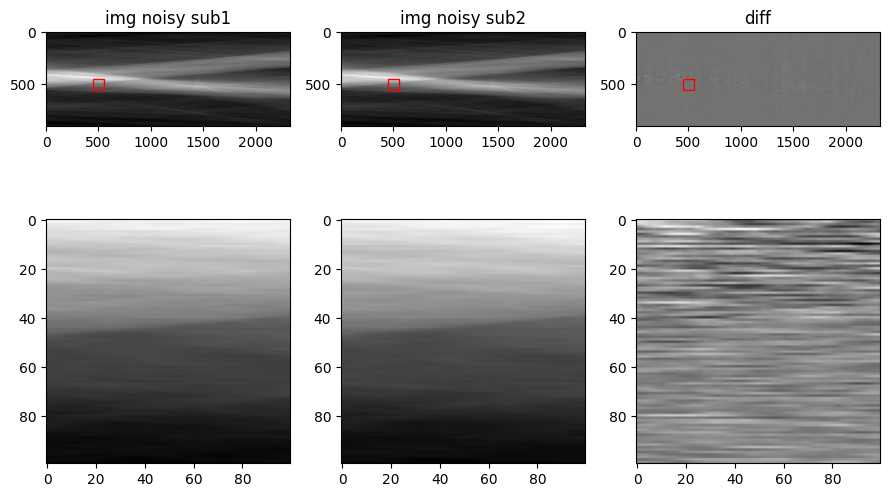

In [16]:
img_noisysub1 = noisy_sub1.detach().cpu().squeeze()
img_noisysub2 = noisy_sub2.detach().cpu().squeeze()
print(img_noisysub1.shape)
plot_images_with_zoom([img_noisysub1, img_noisysub2, img_noisysub1 - img_noisysub2], 
                     ['img noisy sub1', 'img noisy sub2', 'diff'],
                    vmin=None,
                    vmax=None,
                    zoom_center=(500, 500),
                    zoom_size=50,
                    axis=True,
                    )

torch.Size([2326, 2326]) tensor(0.0163) tensor(0.0092)


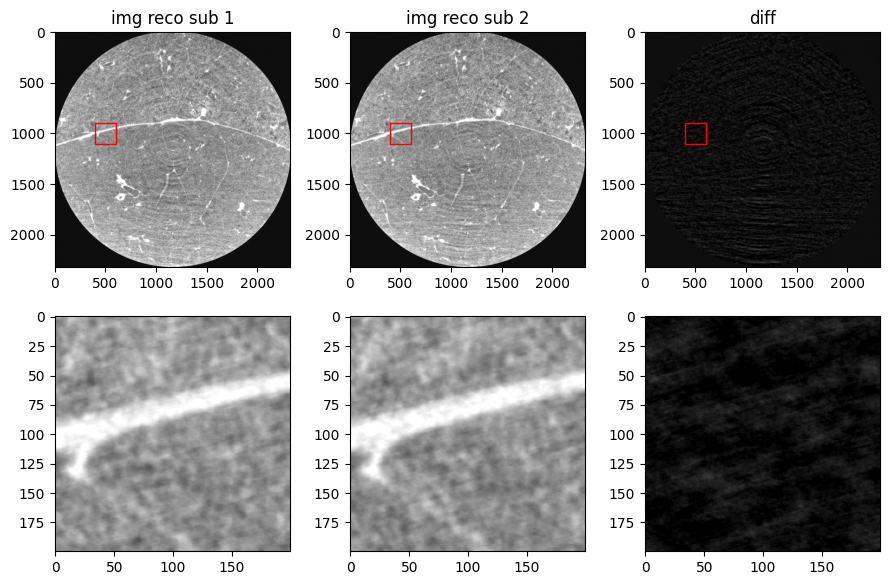

In [17]:
img_reco_sub1 = reco_sub1.detach().cpu().squeeze()
img_reco_sub2 = reco_sub2.detach().cpu().squeeze()
diff  = reco_sub2.detach().cpu().squeeze() - reco_sub1.detach().cpu().squeeze()

mn, std = img_reco_sub1.mean(), img_reco_sub1.std()
vmin = mn - 2*std
vmax = mn + 2*std

print(img_reco_sub2.shape, img_reco_sub2.mean(), img_reco_sub2.std())
plot_images_with_zoom([img_reco_sub1, img_reco_sub2, diff], 
                     ['img reco sub 1', 'img reco sub 2', 'diff'],
                    vmin=vmin,
                    vmax=vmax,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )

tensor(0.0012, device='cuda:0') tensor(0.9241, device='cuda:0')
tensor(0.0114, device='cuda:0') tensor(0.9149, device='cuda:0')


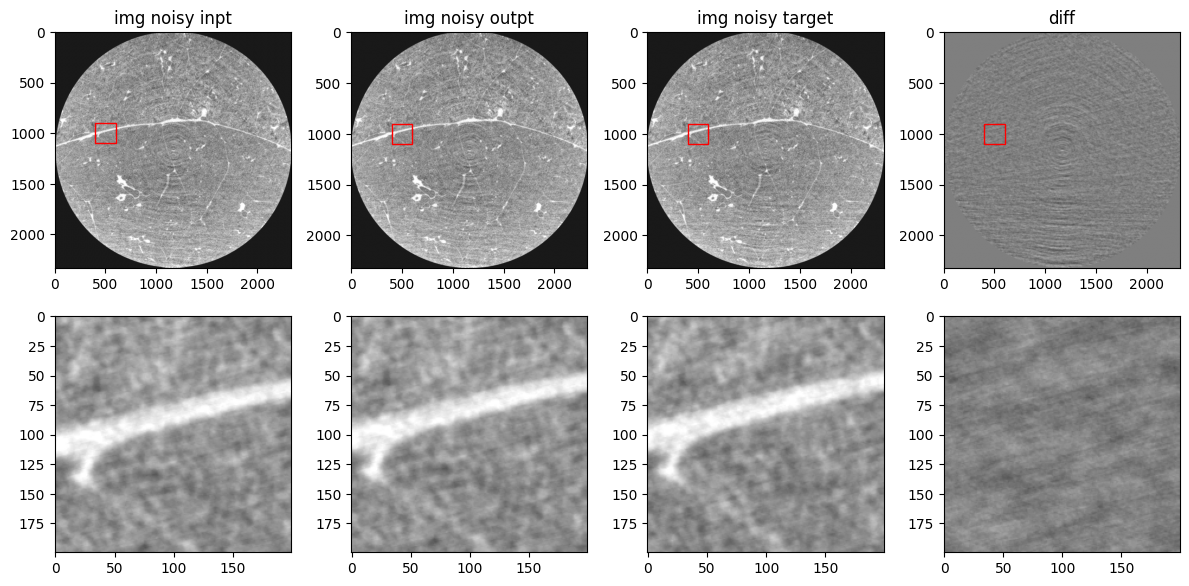

In [18]:
img_list = [img.detach().squeeze().cpu() for img in [noisy_inpt, noisy_output, noisy_target, noisy_output-noisy_target]]
print(noisy_inpt.mean(), noisy_inpt.std())
print(noisy_target.mean(), noisy_target.std())
 
plot_images_with_zoom(img_list, 
                     ['img noisy inpt', 'img noisy outpt', 'img noisy target', 'diff'],
                    vmin=-2,
                    vmax=2,
                    zoom_center=(500, 1000),
                    zoom_size=100,
                    axis=True,
                    )